In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print(train_dataset.element_spec)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGD7RAI/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGD7RAI/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGD7RAI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [ ]:
for example, label in train_dataset.take(1):
  print('text : ', example.numpy())
  print('label : ', label.numpy())

text :  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label :  0


Lecture aléatoire les données de formation et de créer des lots de (text, label)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('text : ', example.numpy()[:4])
  print('label : ', label.numpy()[:4])

text :  [b"This movie has some of the most awesome cars I've ever seen in a movie, and definitely the hottest women, but I would have to say it is still one of the worst movies I've ever seen.<br /><br />Here is the plot, and if you read it with a little inflection, you have the acting as well.<br /><br />Beginning, bring in characters, hot woman singing (obvious lip sync). Music agent or producer comes in, thinks that she is awesome asks her to race. She turns down, too many bad memories. Flash to war hero, back from war, has several fights, and becomes movie hero with attitude that he is better than everyone. Drive off in fast exotic car. Brother races, then dies. Hero to avenge death, cut away to getting weapons from friend. (You have never seen this friend before or after, but seems to really care about him) Are you sure you want to do this; Yes; I mean are you really sure; Yes, give me weapons; are you REALLY sure; Yes; OK, I guess I can't talk you out of it, be careful man, I lov

Creer l'encodeur de text - Traiter les texts en utilisant la couche TextVectorization

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label : text))

vocab = np.array(encoder.get_vocabulary())
print(vocab[:40])

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but' 'film' 'on' 'not' 'you' 'are'
 'his' 'have' 'he' 'be' 'one' 'its' 'at' 'all' 'by' 'an' 'they' 'from'
 'who' 'so' 'like']


In [ ]:
example_encoder = encoder(example)[:3].numpy()
example_encoder

array([[ 11,  18,  44, ...,   0,   0,   0],
       [ 10, 199,   2, ...,   0,   0,   0],
       [852,  20,   6, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print('Original :', example[n].numpy())
  print("Round-trip: ", " ".join(vocab[example_encoder[n]]))

Original : b"This movie has some of the most awesome cars I've ever seen in a movie, and definitely the hottest women, but I would have to say it is still one of the worst movies I've ever seen.<br /><br />Here is the plot, and if you read it with a little inflection, you have the acting as well.<br /><br />Beginning, bring in characters, hot woman singing (obvious lip sync). Music agent or producer comes in, thinks that she is awesome asks her to race. She turns down, too many bad memories. Flash to war hero, back from war, has several fights, and becomes movie hero with attitude that he is better than everyone. Drive off in fast exotic car. Brother races, then dies. Hero to avenge death, cut away to getting weapons from friend. (You have never seen this friend before or after, but seems to really care about him) Are you sure you want to do this; Yes; I mean are you really sure; Yes, give me weapons; are you REALLY sure; Yes; OK, I guess I can't talk you out of it, be careful man, I l

Créer le modèle : 
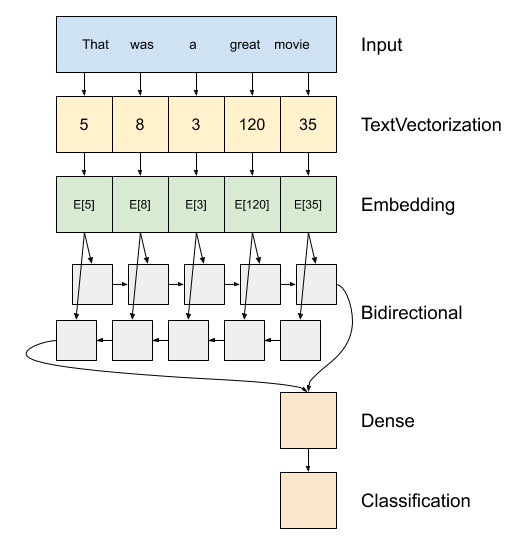

In [ ]:
model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(
                                 input_dim=len(encoder.get_vocabulary()),
                                 output_dim=64,
                                 mask_zero=True # Use masking to handle the variable sequence lengths
                             ),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)
                             ])

In [ ]:
for layer in model.layers:
  print(layer.supports_masking)

False
True
True
True
True


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

print(np.array([sample_text]))
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.']
[0.00785468]


In [ ]:
padding = "the " * 2000

print(np.array([sample_text, padding]))
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'
 'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

In [ ]:
# Compile le modèle

model.compile(optimizer= tf.keras.optimizers.Adam(1e-4),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Former le modele

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 111s 254ms/step - loss: 0.6255 - accuracy: 0.5880 - val_loss: 0.5188 - val_accuracy: 0.7333
Epoch 2/10
391/391 [==============================] - 93s 235ms/step - loss: 0.4662 - accuracy: 0.7747 - val_loss: 0.4940 - val_accuracy: 0.7594
Epoch 3/10
391/391 [==============================] - 93s 235ms/step - loss: 0.4313 - accuracy: 0.8247 - val_loss: 0.4018 - val_accuracy: 0.8401
Epoch 4/10
391/391 [==============================] - 93s 234ms/step - loss: 0.3639 - accuracy: 0.8458 - val_loss: 0.3582 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 92s 234ms/step - loss: 0.3438 - accuracy: 0.8538 - val_loss: 0.3444 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 92s 234ms/step - loss: 0.3330 - accuracy: 0.8594 - val_loss: 0.3365 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 93s 235ms/step - loss: 0.3243 - accuracy: 0.8642 - val_loss: 0.3298 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test loss : ', test_loss)
print('Test accuracy : ', test_acc)

391/391 [==============================] - 49s 125ms/step - loss: 0.3221 - accuracy: 0.8620
Test loss :  0.3221282958984375
Test accuracy :  0.8619999885559082


(0.0, 0.6412516519427299)

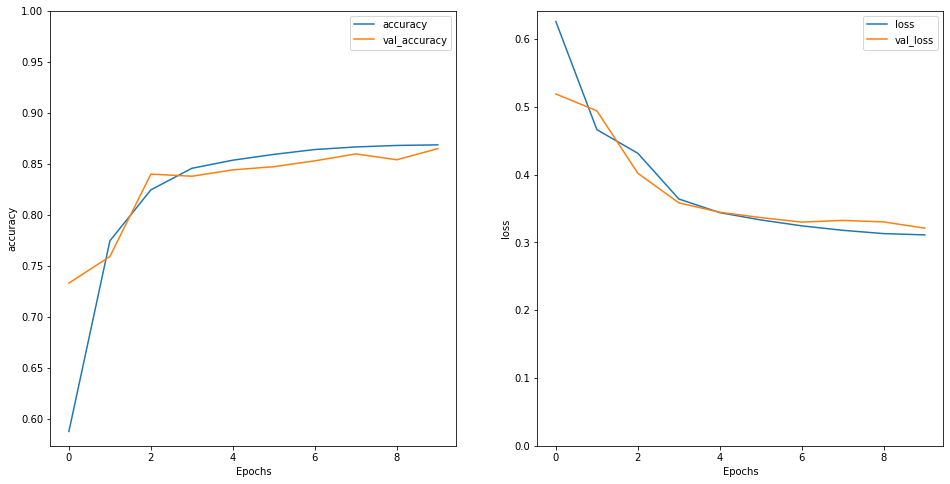

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# Positive sample
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))

print(predictions)

[[0.20517991]]


Empilez deux ou plusieurs couches LSTM

In [ ]:
model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(
                                 input_dim=len(encoder.get_vocabulary()),
                                 output_dim=64,
                                 mask_zero=True
                             ),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
                             ])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 198s 461ms/step - loss: 0.6357 - accuracy: 0.5741 - val_loss: 0.4413 - val_accuracy: 0.7682
Epoch 2/10
391/391 [==============================] - 170s 433ms/step - loss: 0.4017 - accuracy: 0.8216 - val_loss: 0.3736 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 168s 428ms/step - loss: 0.3455 - accuracy: 0.8520 - val_loss: 0.3345 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 171s 435ms/step - loss: 0.3212 - accuracy: 0.8623 - val_loss: 0.3331 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 168s 428ms/step - loss: 0.3147 - accuracy: 0.8648 - val_loss: 0.3206 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 168s 426ms/step - loss: 0.3057 - accuracy: 0.8685 - val_loss: 0.3186 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 169s 430ms/step - loss: 0.3072 - accuracy: 0.8679 - val_loss: 0.3175 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 83s 213ms/step - loss: 0.3154 - accuracy: 0.8603
Test Loss: 0.31541407108306885
Test Accuracy: 0.860319972038269


In [ ]:
# Negative sample
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8822271]]


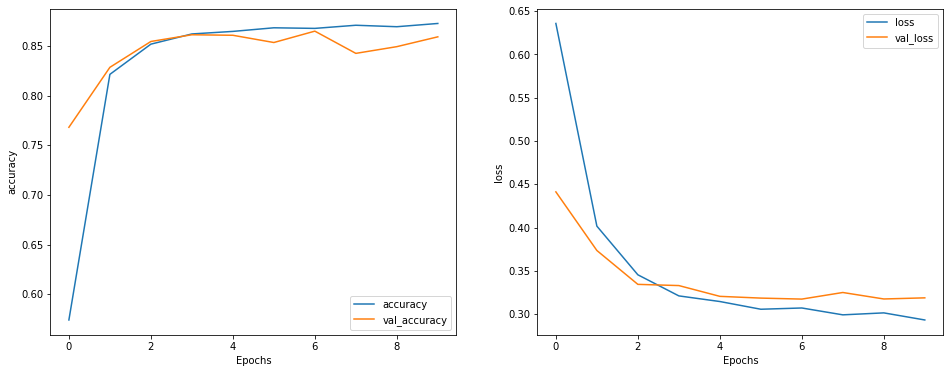

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')